In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from aenum import MultiValueEnum
import pandas as pd
# Basics of Python data handling and visualization
import numpy as np
np.random.seed(42)
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm.auto import tqdm
from os import makedirs, path as op
# Machine learning
import lightgbm as lgb
import joblib
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, ExtractBandsTask, MergeFeatureTask
from eolearn.io import SentinelHubInputTask, VectorImportTask, ExportToTiff
from eolearn.mask import AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, NormalizedDifferenceIndexTask
from sentinelhub import UtmZoneSplitter, BBox, CRS, DataCollection, SHConfig, BBoxSplitter
from utils import (SentinelHubValidData, CountValid, NormalizedDifferenceIndex, ConcatenateData, ValidDataFractionPredicate)

In [2]:
CLIENT_ID = "f32c25a9-438e-44bd-ba96-1d95c33fe03a"
CLIENT_SECRET = "@&-d/1)m!SCR%6L?Ki7&v<cp?2G.1nI([(^mH|]u"
    
config = SHConfig()
config.instance_id = "8288f09c-5b87-49f8-81bc-76106c4581a6"
    
if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
if config.sh_client_id == "" or config.sh_client_secret == "" or config.instance_id == "":
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")
# config.save()

/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dimension of the area is 242185 x 160585 m2
Dimension of the area is 24218 x 16058 pixels


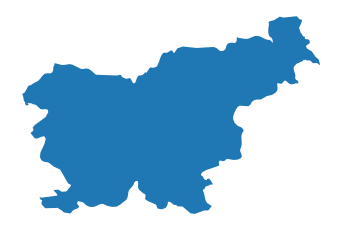

In [3]:

# Folder where data for running the notebook is located
DATA_FOLDER = os.path.join('.', 'example_data')

# Folder where data will be stored
EOPATCH_FOLDER = os.path.join('.', 'eopatches')
EOPATCH_SAMPLES_FOLDER = os.path.join('.', 'eopatches_sampled')
EOPATCH_FOLDER_SLOVENIA = os.path.join('.', 'eopatches_slovenia', 'eopatches')
EOPATCH_SAMPLES_FOLDER_SLOVENIA = os.path.join('.', 'eopatches_sampled_slovenia')
RESULTS_FOLDER = os.path.join('.', 'results')
os.makedirs(EOPATCH_FOLDER, exist_ok=True)
os.makedirs(EOPATCH_SAMPLES_FOLDER, exist_ok=True)
os.makedirs(RESULTS_FOLDER, exist_ok=True)

# Load geojson file
countries = gpd.read_file('data.gpkg')
country = countries[countries.SOVEREIGNT.str.contains('Slovenia')]
#country = gpd.read_file('kiev.json')
country_crs = CRS.UTM_33N

if country.crs != country_crs:
    country = country.to_crs(crs=country_crs.pyproj_crs())

country_shape = country.geometry.tolist()[-1]
width_pix = int((country_shape.bounds[2]-country_shape.bounds[0])/10)
height_pix = int((country_shape.bounds[3]-country_shape.bounds[1])/10)

print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2]-country_shape.bounds[0],country_shape.bounds[3]-country_shape.bounds[1]))
print('Dimension of the area is {} x {} pixels'.format(width_pix, height_pix))

bbox_splitter = BBoxSplitter([country_shape], country_crs, (25, 17))
bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_splitter.bbox_list]
idxs_x = [info['index_x'] for info in bbox_splitter.info_list]
idxs_y = [info['index_y'] for info in bbox_splitter.info_list]

df = pd.DataFrame({'index_x':idxs_x, 'index_y':idxs_y})
common_crs = bbox_splitter.bbox_list[0].crs
gdf = gpd.GeoDataFrame(df, crs=common_crs.pyproj_crs(), geometry=geometry)

# Plot country
country.plot()
plt.axis('off');

In [4]:
ID = 100
# Obtain surrounding 5x5 patches
patchIDs = []
for idx, (bbox, info) in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 2 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 2):
        patchIDs.append(idx)

# Check if final size is 3x3
if len(patchIDs) != 5*5:
    print('Warning! Use a different central patch ID, this one is on the border.')

# Change the order of the patches (useful for plotting)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(5, 5))).ravel()

# Save to shapefile
shapefile_name = 'ukraine_500x500.gpkg'
gdf.to_file(os.path.join(RESULTS_FOLDER, shapefile_name), driver='GPKG')

/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# Load sampled eopatches
sampled_eopatches = []

for i in range(len(patchIDs)):
    sample_path = os.path.join('./eopatches_sampled_slovenia/', f'eopatch_{i}')
    sampled_eopatches.append(EOPatch.load(sample_path, lazy_loading=True))

In [6]:
test_ID = [0, 8, 16, 19, 20,1,2,3,4,5,6,7,9,11,12,13,14,15,17,18,21,22,23,24]
test_eopatches = [sampled_eopatches[i] for i in test_ID]
train_ID = [i for i in range(len(patchIDs)) if i not in test_ID]
train_eopatches = [sampled_eopatches[i] for i in train_ID]

In [7]:
# Set the features and the labels for train and test sets
features_train = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in train_eopatches])
labels_train = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in train_eopatches])
p1, t, w, h, f = features_train.shape
 
# features_test = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in test_eopatches])
# labels_test = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in test_eopatches])

# Get shape
# p2, t, w, h, f = features_test.shape
# p = p1 + p2

# features_test = np.moveaxis(features_test, 1, 3).reshape(p2 * w * h, t * f)
# labels_test = np.moveaxis(labels_test, 1, 2).reshape(p2 * w * h)

features_train = np.moveaxis(features_train, 1, 3).reshape(p1 * w * t * h, f)
labels_train = np.moveaxis(labels_train, 1, 2).reshape(w)
arr = []
for i in range(len(labels_train)):
    for j in range(0,t):
        arr.append(labels_train[i])
labels_train = np.array(arr)

# Remove points with no reference from training (so we dont train to recognize "no data")
# mask_train = labels_train == 0
# features_train = features_train[~mask_train]
# labels_train = labels_train[~mask_train]

# # Remove points with no reference from test (so we dont validate on "no data", which doesn't make sense)
# mask_test = labels_test == 0
# features_test = features_test[~mask_test]
# labels_test = labels_test[~mask_test]

In [ ]:
first = features_train[:,0]
second = features_train[0,:]

dic = dict(zip(first, labels_train))
final = {key:value for key,value in dic.items() if value != 0}
features, labels = zip(*final.items())



In [8]:
features_train

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 0.11852857,  0.09105714,  0.08424286, ...,  0.52148694,
        -0.49247682, -0.21397035],
       [ 0.11051428,  0.08942857,  0.08197143, ...,  0.49284428,
        -0.45893472, -0.1451616 ],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [9]:
labels_train

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [ ]:
# Load the model
model_path = os.path.join(RESULTS_FOLDER, 'model_SI_LULC.pkl')
model = joblib.load(model_path)

# Predict the test labels
predicted_labels_test = model.predict(features_test)

In [ ]:
class PredictPatchTask(EOTask):
    """
    Task to make model predictions on a patch. Provide the model and the feature,
    and the output names of labels and scores (optional)
    """
    def __init__(self, model, features_feature, predicted_labels_name, predicted_scores_name=None):
        self.model = model
        self.features_feature = features_feature
        self.predicted_labels_name = predicted_labels_name
        self.predicted_scores_name = predicted_scores_name

    def execute(self, eopatch):
        features = eopatch[self.features_feature]
        features = features[:2500000]
        t, w, h, f = features.shape
        features = np.moveaxis(features, 0, 2).reshape(w * h * t, f)

        predicted_labels = self.model.predict(features)
        predicted_labels = predicted_labels.reshape(w, h)
        predicted_labels = predicted_labels[..., np.newaxis]
        eopatch[(FeatureType.MASK_TIMELESS, self.predicted_labels_name)] = predicted_labels

        if self.predicted_scores_name:
            predicted_scores = self.model.predict_proba(features)
            _, d = predicted_scores.shape
            predicted_scores = predicted_scores.reshape(w, h, d)
            eopatch[(FeatureType.DATA_TIMELESS, self.predicted_scores_name)] = predicted_scores

        return eopatch

In [ ]:
# LOAD EXISTING EOPATCHES
load = LoadTask(EOPATCH_SAMPLES_FOLDER_SLOVENIA)

# PREDICT
predict = PredictPatchTask(model, (FeatureType.DATA, 'FEATURES'), 'LBL_GBM', 'SCR_GBM')

# SAVE
save = SaveTask(EOPATCH_SAMPLES_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# EXPORT TIFF
export_tiff = ExportToTiff((FeatureType.MASK_TIMELESS, 'LBL_GBM'))
tiff_location = os.path.join(RESULTS_FOLDER, 'predicted_tiff')
os.makedirs(tiff_location, exist_ok=True)

workflow = LinearWorkflow(
    load,
    predict,
    export_tiff,
    save
)

In [ ]:
# Create a list of execution arguments for each patch
execution_args = []
for i in range(len(patchIDs)):
    execution_args.append(
        {
            load: {'eopatch_folder': f'eopatch_{i}'},
            export_tiff: {'filename': f'{tiff_location}/prediction_eopatch_{i}.tiff'},
            save: {'eopatch_folder': f'eopatch_{i}'}
        }
    )

# Run the executor
executor = EOExecutor(workflow, execution_args)
executor.run(workers=1, multiprocess=False)
executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(f'Execution failed EOPatches with IDs:\n{failed_ids}\n'
                       f'For more info check report at {executor.get_report_filename()}')

In [ ]:
# ValueError: During execution of task PredictPatchTask: cannot reshape array of size 6250000 into shape (500,500)